<a href="https://colab.research.google.com/github/Mauville/MedCLIP/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedClip

Imports

In [ ]:
!pip install timm
!pip install transformers

In [ ]:
from IPython import display as ipythondisplay
from torch import nn
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as A
import cv2
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import timm
import torch
import torch.nn.functional as F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Some pre-preocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/Shareddrives/DeepLearning/datav2/removeNAN_withImprovedGrammar.csv') 

Mounted at /content/drive


In [ ]:

# Ops to consolidate dataset to the notebook standards

# Create a compound column using other columns. Comment lines for less or more complexity

# "a sagital plane
# MR scan
# of cranial trauma
# on a 58 year old male
# diagnosed with brain death
df["grouped_diag"] = df.apply(lambda row: \
                              "a " + str(row.Plane) + " plane "\
                              + str(row.Core_Modality) + " scan"\
                              + " of "  + str(row.Location) + " " + str(row.Category)\
                              + " on a " + str(row.Patient_Age) + " year old " + str(row.Patient_Gender)
                              + " depicting "+ str(row.Case_Diagnosis)
                              , axis = 1)


#  reformat to fit the shape
#  	image 	caption id
df.rename(columns={"filename":"image", "grouped_diag":"caption"},inplace=True)
needed_cols = ["image","caption"]
df = df[df.columns.intersection(needed_cols)]

image_path = "/content/drive/Shareddrives/DeepLearning/datav2/output"
captions_path = "/content/drive/Shareddrives/DeepLearning/datav2"

#  	image 	caption 	
# 0 	1000268201_693b08cb0e.jpg 	A child in a pink dress is climbing up a set o... 	
# 1 	1000268201_693b08cb0e.jpg 	A girl going into a wooden building . 	
# 2 	1000268201_693b08cb0e.jpg 	A little girl climbing into a wooden playhouse . 	
# 3 	1000268201_693b08cb0e.jpg 	A little girl climbing the stairs to her playh... 	
# 4 	1000268201_693b08cb0e.jpg 	A little girl in a pink dress going into a woo... 	

# I have no idea why tf he writes the dataset to memory but whatev
df.to_csv(captions_path + "/captions.csv", index=False)

df.head()

,image,caption
0,synpic100377.jpg,a Multiple or Montage plane CT scan of Musculo...
1,synpic100378.jpg,a Multiple or Montage plane CT scan of Musculo...
2,synpic100379.jpg,a Multiple or Montage plane CT scan of Musculo...
3,synpic100380.jpg,a Oblique plane XR scan of Musculoskeletal Tra...
4,synpic100381.jpg,a Multiple or Montage plane MR scan of Musculo...


## Config
Global config for all the project.

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 12
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    saved_model_clinical = '/content/drive/Shareddrives/DeepLearning/datav2/withDiagnostics2.pt'
    trained_model = 'clinical_bert_weights.pt'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    clinical_encoder_model = "emilyalsentzer/Bio_ClinicalBERT"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

Create globally available test and validation datasets.

In [ ]:
from sklearn.model_selection import train_test_split

def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    train, test = train_test_split(dataframe, test_size=.1, train_size=.9, shuffle=True, random_state=77,stratify=None)
    return train, test

testing_df , training_df = make_train_valid_dfs()

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

In [ ]:
# Custom dataset object. Will tokenize text and apply transforms to images before yielding them.

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.skippedImgCount = 0
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }
        ################################
        # MASSIVE GDRIVE BUG HERE
        # Sometimes, reading an image from disk fails, which crashes the entirety of the program
        # Here we default to adding the image at dataset[0]
        ################################
        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        if image is None:
          self.skippedImgCount += 1
          return self.__getitem__(1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )



## Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            # self.model = DistilBertModel.from_pretrained(model_name)

            # Use Bio-ClinicalBERT
            self.model = AutoModel.from_pretrained(CFG.clinical_encoder_model)

        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
# Get both image and text encodings into a same size matrix
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

#### Check the cell below this code block for the continue of the explanations

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

The perfect relationship between encoded images and captions is described by their encoded representations being the same.
This similarity can easily be measured by looking at the softmax between the dot product of the encoded inputs; a perfect encoding will yield the identity matrix.
The loss on each iteration is calculated using cross entropy on the dot product between the encodings.

In [ ]:
# A simple Example


batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## Train

In [ ]:


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    history = []
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        

        loss_meter.update(loss.item(), count)

        history.append(loss.cpu().detach().numpy().mean())
        
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    plotter.plot(history)
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter





def main():
    train_df = training_df 
    valid_df = testing_df
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')

    history = []
    for epoch in range(CFG.epochs): 
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        torch.save(model.state_dict(), "temp.pt")
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)
    print(f"CAREFUL! I had to skip {train_loader.dataset.skippedImgCount} to finish. This introduces heavy bias to whatever dataset[0] was at the time of training")    


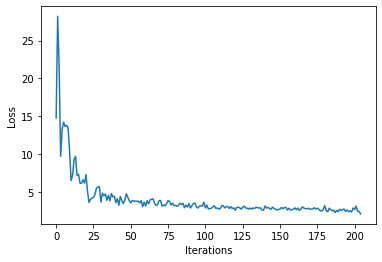

  0%|          | 0/1843 [00:00<?, ?it/s]

In [ ]:
# Run to start training
main()

Auto copy weights file to Drive so I can sleep in  peace.

---



In [ ]:
!cp -r './best.pt' /content/drive/Shareddrives/DeepLearning/datav2/withDiagnostics2.pt

## Inference

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

def get_text_embeddings(valid_df, model_path):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            text_features = model.text_encoder(
                input_ids=batch["input_ids"].to(CFG.device), attention_mask=batch["attention_mask"].to(CFG.device)
            )
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
    return model, torch.cat(valid_text_embeddings)
    

In [ ]:
# Aliased to avoid bad sampling
valid_df = testing_df

In [ ]:

model, image_embeddings = get_image_embeddings(valid_df, CFG.saved_model_clinical)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1843 [00:00<?, ?it/s]

In [ ]:
model, text_embeddings = get_text_embeddings(valid_df, CFG.saved_model_clinical)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1843 [00:00<?, ?it/s]

### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    # tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    metrics = get_metrics(matches, query)
    save_metrics('distil_metrics_results.csv', metrics)
    print(matches)
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

In [ ]:
def find_matches_from_image(model, text_embeddings, image_query, captions, n=9):
    
    image = cv2.imread(f"{CFG.image_path}/{image_query}")
    if image is None:
      print("GDRIVE DIDN'T READ AGAIN!")
      return 'NO_IMG_IN_GDRIVE'

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = get_transforms("valid")(image=image)['image']

    # Dymb loader
    tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    dummy_df = pd.DataFrame.from_dict({"image": [image_query], "caption":[""]})
    dumb_loader = build_loaders(dummy_df, tokenizer, mode="valid")

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dumb_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)

    image_embeddings_n = F.normalize(image_embeddings[0], p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = image_embeddings_n @ text_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [captions[idx] for idx in indices[::5]]
    
    return matches

In [ ]:
# find_matches(model, image_embeddings, query="a frontal XR scan of spine trauma", image_filenames=valid_df['image'].values, n=9)

This is how we use this function. And the results:
(The results in the blog post and the one at the beginning of the notebook were achieved with training on the 30k version)

## Metrics


In [ ]:
!pip install nltk
!pip install rouge
!pip install pycocoevalcap
!pip install opencv-python

     |████████████████████████████████| 104.3 MB 517 kB/s 


In [ ]:
!pip install -U nltk
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 749 kB 45.5 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# https://arxiv.org/pdf/1504.00325.pdf
# To ensure consistency in evaluation of automatic caption generation algorithms, an
# evaluation server is used. The evaluation server receives candidate captions and scores them using several popular metrics, including
# BLEU, METEOR, ROUGE and CIDEr.

from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu as BleuCoco
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from pycocoevalcap.cider.cider import Cider

import matplotlib.pyplot as plt
import pandas as pd

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        scorers = [
            (BleuCoco(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (MeteorCoco(),"METEOR"),
            (RougeCoco(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

class EvaluationServer:
  def __init__(self):
    self.last_idx = 0
    self.groundtruths = dict()
    self.hypothesis = dict()

  def add(self, caption, matches):
    print(f'Adding caption: {self.last_idx}  to evaluator')
    start_idx = self.last_idx
    for i, match in enumerate(matches):
      idx = start_idx + i
      self.groundtruths[idx] = [{'image_id': idx, 'caption': caption}]
      self.hypothesis[idx] = [{'image_id': idx, 'caption': match}]
      self.last_idx += 1

  def present_metrics(self):
    print(f'Calculating scores for all {self.last_idx} captions:\n')
    rng = range(self.last_idx)
    evalObj = COCOEvalCap(rng,self.groundtruths,self.hypothesis)
    evalObj.evaluate()
    scores = evalObj.eval

    df = pd.DataFrame(scores, columns=scores.keys(), index=['one'])

    fig, ax = plt.subplots() 

    # Hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    print('Model scores using Microsofts Coco Evaluation Server:')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')



In [ ]:
from rouge import Rouge
from nltk.tokenize import TreebankWordTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider
import matplotlib.pyplot as plt
import pandas as pd
import cv2

plt.rcParams['figure.figsize'] = [20, 7]

# This tokenizer performs the following steps:
#   split standard contractions, e.g. don't -> do n't and they'll -> they 'll
#   treat most punctuation characters as separate tokens
#   split off commas and single quotes, when followed by whitespace
#   separate periods that appear at the end of line
def tokenize(s):
  return TreebankWordTokenizer().tokenize(s)

# Cumulative scores of bluee, n gram scores.
# Match ngrams from candidate to n-grams in reference text. 
# Regardless of word order.
def get_bleu(query, groundtruth):
    reference = [tokenize(groundtruth)]
    candidate = tokenize(query)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    bleu_3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33))
    bleu_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    return {"bleu_1": bleu_1, "bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}

# Rouge has different variants, the recomemnded one is rouge-l, 
# which stands calculates precisio,  recall and F1-measure based
# on the length of the longest common subsequence.
# The desired metrics result is the F1-measure.
def get_rouge(query, groundtruth, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(query, groundtruth)
    return rouge_scores[0][variant][measure]

# Meteor evaluates the caption by first calculating bleu_1
# between generated and ground truth to find matching results.
# Computes harmonic mean.
def get_meteor(query, groundtruth):
    hypothesis = [tokenize(query)]
    reference = tokenize(groundtruth)
    return meteor_score(hypothesis, reference)

# Somethings wrong:: https://gist.github.com/kracwarlock/c979b10433fe4ac9fb97
# got 0.0
def get_cider(query, groundtruth):
    tokenizer = PTBTokenizer()
    gts  = tokenizer.tokenize({0: [{"image_id": 0, "caption": groundtruth}]})
    res = tokenizer.tokenize({0: [{"image_id": 0, "caption": query}]})
    cider = Cider()
    return cider.compute_score(gts,res)

def get_scores(query, groundtruth):
    scores = dict()
    for k, v in get_bleu(query, groundtruth).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(query, groundtruth)
    scores["meteor"] = get_meteor(query, groundtruth);
    # vale, arr = get_cider(query, groundtruth)
    return scores

def present_scores(imagename, caption, matches):
    headers = []
    scores = []

    print('Recomended captions:\n')

    for match in matches:

      score = get_scores(match, caption)
      scores.append(score)
      headers = score.keys()

      print(f'\t- {match}')

    print('Scores for every recommended caption:\n')

    # Set scores dataframe
    df = pd.DataFrame(scores, columns=headers, index=matches)
    df.update(df.applymap('{:.4f}'.format))

    # Create table
    fig, ax = plt.subplots(2,1)

    # Hide axes
    fig.patch.set_visible(False)
    ax[1].axis('off')
    ax[1].axis('tight')
    # ax[2].axis('off')
    # ax[2].axis('tight')

    # mdf = pd.DataFrame(df.index, columns=["Matches"])

    # Create table
    # table = ax[1].table(cellText=mdf.values, colLabels=mdf.columns, loc='center')
    table = ax[1].table(cellText=df.values, colLabels=df.columns, loc='center')

    # Create image
    image = cv2.imread(f"{CFG.image_path}/{imagename}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    ax[0].axis('off')
    plt.show()



In [ ]:
def get_n_random_image_match(n):
  imagesdf = testing_df.sample(n=n)
  # print(imagesdf)
  for index, row in imagesdf.iterrows():
    print(f"Image inserted: {row['image']}\nReal caption: {row['caption']}\n")

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    present_scores(row.image, row.caption, matches)

def evaluate_model(nsamples=40):
  imagesdf = testing_df.sample(n=nsamples)
  eval = EvaluationServer()
  # print(imagesdf)
  for index, row in imagesdf.iterrows():

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    if matches != 'NO_IMG_IN_GDRIVE':
      eval.add(row['caption'], matches)

  eval.present_metrics()
    

Image inserted: synpic50555.jpg
Real caption: a Axial plane CT scan of Brain and Neuro Vascular on a 20 year old  male depicting DVA, Developmental Venous Anomaly, venous angioma



  0%|          | 0/1 [00:00<?, ?it/s]

Recomended captions:

	- a Axial plane CT scan of Brain and Neuro Cyst, benign on a 27 year old  male depicting Colloid cyst of the third ventricle
	- a Axial plane CT scan of Brain and Neuro Vascular on a 36 year old  male depicting Acute Stroke, Hemorrhage in Basal Ganglia
	- a Axial plane CT scan of Brain and Neuro Vascular on a 37 year old  male depicting Cerebral infarction, hyperdense middle cerebral artery sign
Scores for every recommended caption:



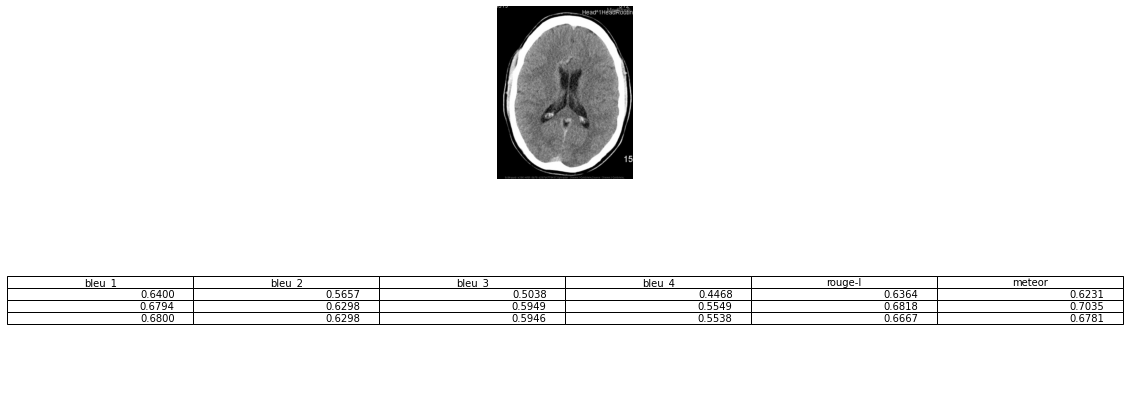

Image inserted: synpic16551.jpg
Real caption: a Coronal plane MR scan of Musculoskeletal Trauma on a 17 year old  female depicting Avascular Necrosis Reparative phase on Nuclear Medicine Scan confirmed by MRI appearance.



  0%|          | 0/1 [00:00<?, ?it/s]

Recomended captions:

	- a Axial plane MR scan of Musculoskeletal Trauma on a 22 year old  male depicting Lateral Femoral Notch Sign
	- a Axial plane MR scan of Musculoskeletal Anatomy, Normal Variant on a 45 year old  male depicting Normal Shoulder radiography, MRI and gross sections
	- a Axial plane MR scan of Musculoskeletal Anatomy, Normal Variant on a 45 year old  male depicting Normal Shoulder radiography, MRI and gross sections
Scores for every recommended caption:



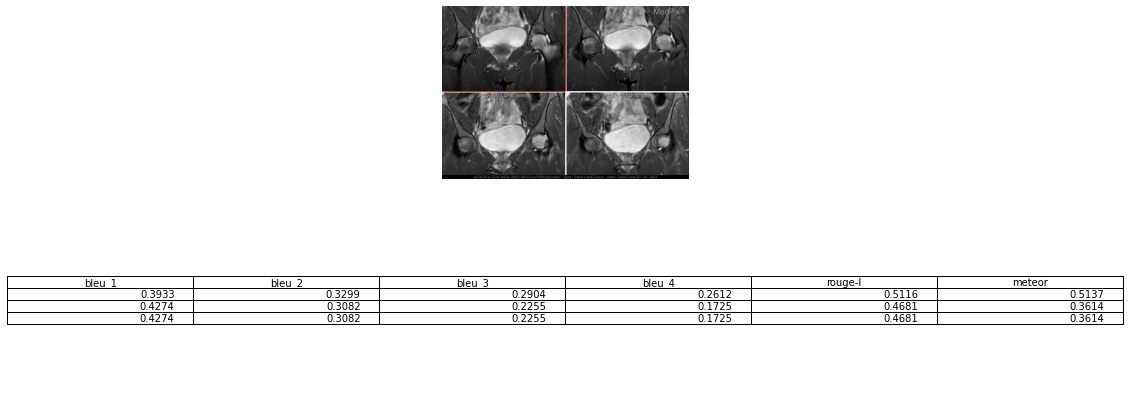

Image inserted: synpic42312.jpg
Real caption: a Axial plane MR scan of Generalized Mnemonic on a 17 year old  female depicting Hemimegalencephaly with Polymicrogyria



  0%|          | 0/1 [00:00<?, ?it/s]

Recomended captions:

	- a Axial plane MR scan of Brain and Neuro Congenital, genetic on a 9 year old  male depicting Tuberous Sclerosis Complex
	- a Axial plane MR scan of Brain and Neuro Congenital, genetic on a 9 year old  male depicting Tuberous Sclerosis Complex
	- a Axial plane MR scan of Brain and Neuro Congenital, genetic on a 49 year old  female depicting Lipoma of the corpus callosum.
Scores for every recommended caption:



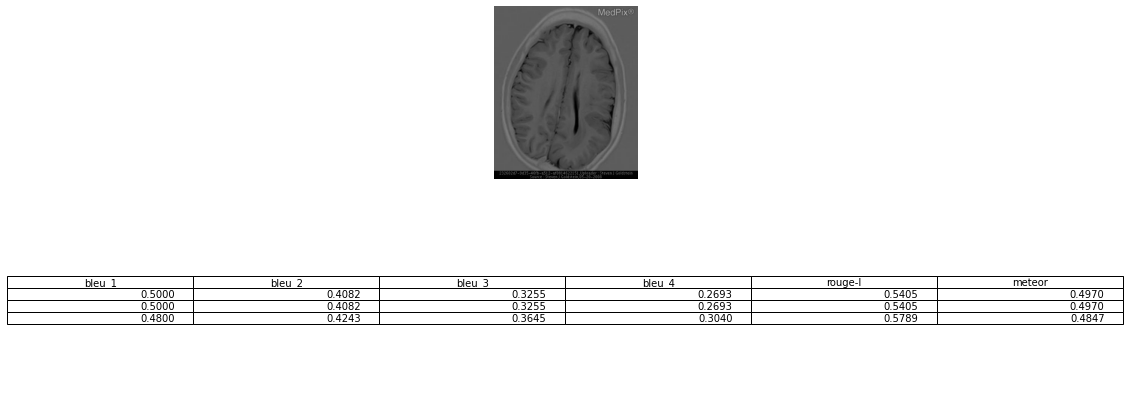

Image inserted: synpic22927.jpg
Real caption: a Axial plane CT scan of Cardiovascular
 Congenital, malformation on a 39 year old  male depicting Double Aortic Arch



  0%|          | 0/1 [00:00<?, ?it/s]

Recomended captions:

	- a Axial plane CT scan of Abdomen
 Infarction and/or Necrosis on a 57 year old  female depicting Primary pneumatosis intestinalis.
	- a Axial plane CT scan of Gastrointestinal Hypoxic or Ischemic on a 57 year old  female depicting Ischemic colitis
	- a Axial plane CT scan of Gastrointestinal Neoplasm, benign on a 45 year old  female depicting Focal Nodular Hyperplasia
Scores for every recommended caption:



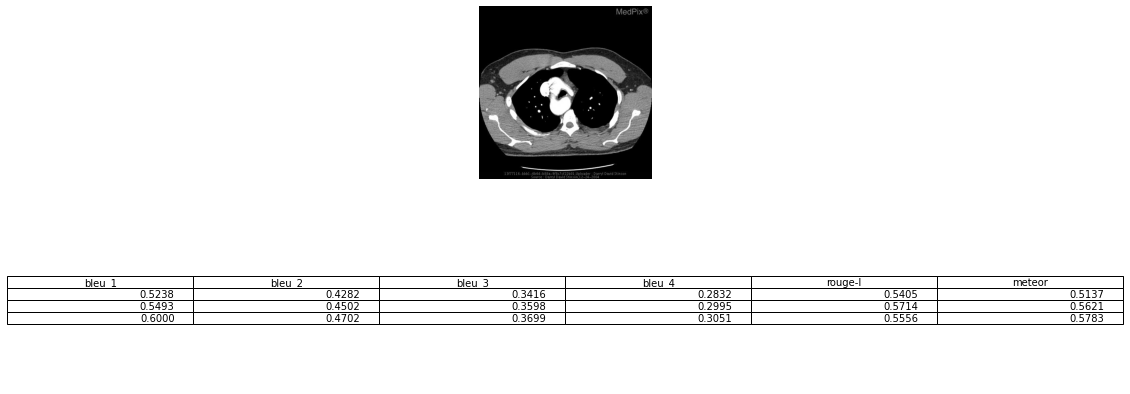

Image inserted: synpic50915.jpg
Real caption: a Sagittal plane MR scan of Brain and Neuro Neoplasm, non-glial on a 24 year old  female depicting Arachnoid Cyst, Sella



  0%|          | 0/1 [00:00<?, ?it/s]

Recomended captions:

	- a Sagittal plane MR scan of Brain and Neuro Neoplasm, glial on a 25 year old  male depicting Fibrillary astrocytoma, WHO Grade 2 to 3
	- a Sagittal plane MR scan of Brain and Neuro Neoplasm, glial on a 11 year old  male depicting Papillary Glioneuronal Tumor, low grade
	- a Sagittal plane MR scan of Brain and Neuro Neoplasm, non-glial on a 68 year old  male depicting Meningioma, multiple
Scores for every recommended caption:



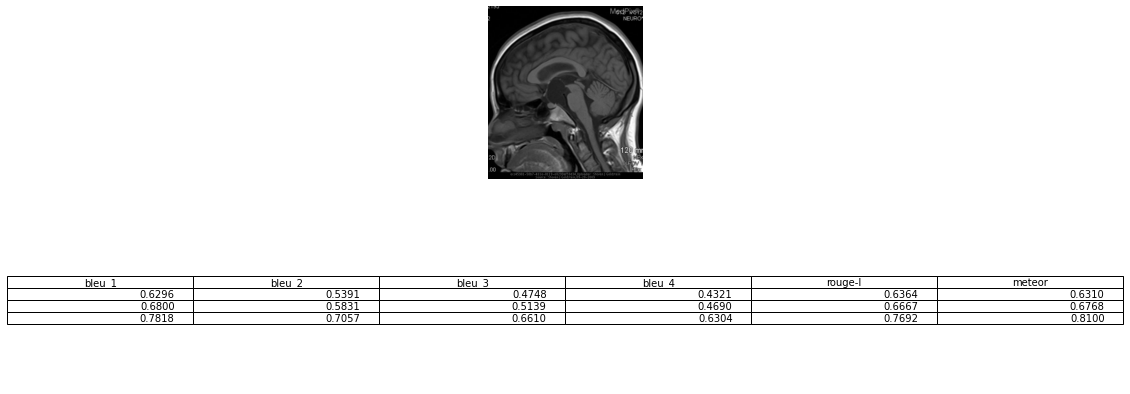

In [ ]:
get_n_random_image_match(5)

  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 0  to evaluator
GDRIVE DIDN'T READ AGAIN!


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 3  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 6  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 9  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 12  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 15  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 18  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 21  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 24  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 27  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 30  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 33  to evaluator
GDRIVE DIDN'T READ AGAIN!


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 36  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 39  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 42  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 45  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 48  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 51  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 54  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 57  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 60  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 63  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 66  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 69  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 72  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 75  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 78  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 81  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 84  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 87  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 90  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 93  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 96  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 99  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 102  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 105  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 108  to evaluator


  0%|          | 0/1 [00:00<?, ?it/s]

Adding caption: 111  to evaluator
Calculating scores for all 114 captions:

computing Bleu score...
{'testlen': 2586, 'reflen': 2634, 'guess': [2586, 2472, 2358, 2244], 'correct': [1493, 1015, 681, 514]}
ratio: 0.9817767653754815
Bleu_1: 0.567
Bleu_2: 0.478
Bleu_3: 0.402
Bleu_4: 0.347
computing METEOR score...
METEOR: 0.267
computing Rouge score...
ROUGE_L: 0.582
computing CIDEr score...
CIDEr: 0.428
Model scores using Microsofts Coco Evaluation Server:


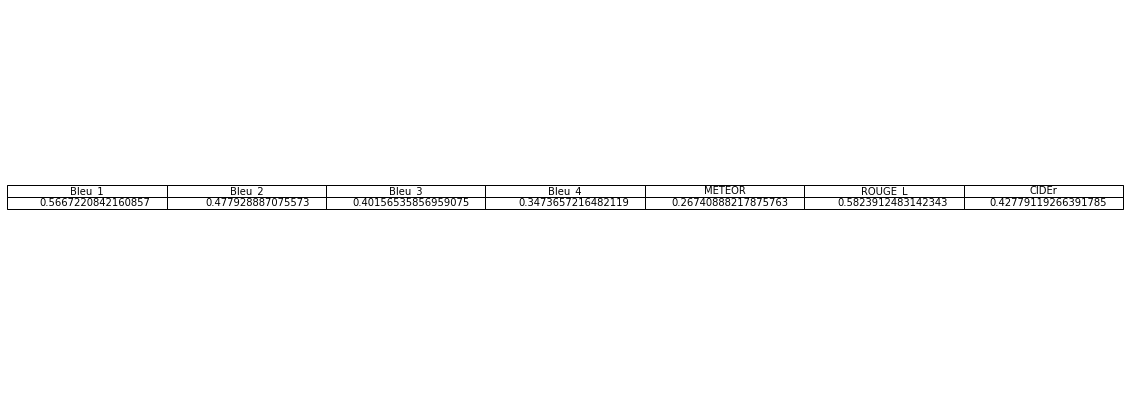

In [ ]:
evaluate_model(40)